In [1]:
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
## Cleaning listings.csv to strip spaces that affected joining my tables.
df = pd.read_csv('listings.csv')
df['City'] = df['City'].str.strip()
df = df.replace(' None', 'None')
df.to_csv('cleaned_listings.csv', index=False)

In [3]:
## Creating SQL Database in order to join datasets in order to create a final clean output dataset
conn = sqlite3.connect('final_project.db',detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)
cursor = conn.cursor()

def create_table1(filename, table):
    cursor.execute(f"DROP TABLE IF EXISTS '{table}'")
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS '{table}' (
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
    City TEXT,
    Address TEXT,
    County TEXT,
    Sqft INTEGER,
    beds INTEGER,
    baths INTEGER,
    Sqft_of_Lot INTEGER,
    Price INTEGER
    );
    """)

    with open(filename, 'r') as f_in:
        reader = csv.reader(f_in)
        next(reader)
        for row in reader:
            try:
                cursor.execute(f"""
                INSERT INTO '{table}' (City, Address, County, Sqft, Beds, Baths, Sqft_of_Lot, Price)
                VALUES('{row[1]}', '{row[0]}', '{row[2]}', '{row[3]}', '{row[4]}', '{row[5]}', '{row[6]}','{row[7]}');
                """)
            except sqlite3.Error as e:
                print(f"Error inserting row {row}: {e}")

def create_table2(filename,table):
    cursor.execute(f"DROP TABLE IF EXISTS '{table}'")
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS '{table}' (
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
    City TEXT,
    County TEXT,
    Violent_Crime REAL,
    Violent_Crime_Per_1000 REAL,
    Property_Crime REAL,
    Property_Crime_Per_1000 REAL
    );
    """)

    with open(filename, 'r') as f_in:
        reader = csv.reader(f_in)
        next(reader)
        for row in reader:
            try:
                cursor.execute(f"""
                INSERT INTO '{table}' (City, County, Violent_Crime, Violent_Crime_Per_1000, Property_Crime, Property_Crime_Per_1000)
                VALUES ('{row[0]}', '{row[1]}', '{row[2]}', '{row[3]}', '{row[4]}', '{row[5]}');
                """)
            except sqlite3.Error as e:
                print(f"Error inserting row {row}: {e}")

def create_table3(filename, table):
    cursor.execute(f"DROP TABLE IF EXISTS '{table}'")
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS '{table}' (
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
    City TEXT,
    County TEXT,
    Income_Per_Capita INTEGER,
    Median_Household_Income INTEGER
    );
    """)

    with open(filename, 'r') as f_in:
        reader = csv.reader(f_in)
        next(reader)
        for row in reader:
            try:
                cursor.execute(f"""
                INSERT INTO '{table}'(City, County, Income_Per_Capita, Median_Household_Income)
                VALUES ('{row[0]}', '{row[1]}', '{row[2]}', '{row[3]}'); 
                """)
            except sqlite3.Error as e:
                    print(f"Error inserting row {row}: {e}")


def create_table4(filename, table):
    cursor.execute(f"DROP TABLE IF EXISTS '{table}'")
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS '{table}' (
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
    City TEXT,
    Rank INTEGER,
    Number_of_Elementary_Schools INTEGER,
    Number_of_Middle_Schools INTEGER,
    Number_of_High_Schools INTEGER,
    Number_of_Private_Schools INTEGER,
    Rank_Score REAL
    );
    """)

    with open(filename, 'r') as f_in:
        reader = csv.reader(f_in)
        next(reader)
        for row in reader:
            try:
                cursor.execute(f"""
                INSERT INTO '{table}'(City, Rank, Number_of_Elementary_Schools, Number_of_Middle_Schools, Number_of_High_Schools, Number_of_Private_Schools, Rank_Score)
                VALUES ('{row[0]}', '{row[1]}', '{row[2]}', '{row[3]}', '{row[4]}', '{row[5]}', '{row[6]}'); 
                """)
            except sqlite3.Error as e:
                    print(f"Error inserting row {row}: {e}")

## Using previously defined functions to create tables in the SQL database
create_table1('cleaned_listings.csv', 'listings_table')
create_table2('Crime_Rate.csv', 'crime_rate_table')
create_table3('Income.csv', 'income_table')
create_table4('school_ranking.csv', 'school_ranking_table')

conn.commit()
conn.close()


In [4]:
## Joining my previously created tables into one table that will be used for analysis. 
conn = sqlite3.connect('final_project.db', detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)
cur = conn.cursor()

cur.execute(f"""
SELECT l.City, l.Address, COALESCE(l.County, c.County) AS County, l.Sqft, l.beds, l.baths, l.Sqft_of_Lot, l.price,
       COALESCE(c.Violent_Crime, cc.Violent_Crime) AS Violent_Crime, 
       COALESCE(c.Violent_Crime_Per_1000, cc.Violent_Crime_Per_1000) AS Violent_Crime_Per_1000,
       COALESCE(c.Property_Crime, cc.Property_Crime) AS Property_Crime,
       COALESCE(c.Property_Crime_Per_1000, cc.Property_Crime_Per_1000) AS Property_Crime_Per_1000,
       COALESCE(i.Income_Per_Capita, ic.Income_Per_Capita) AS Income_Per_Capita, 
       COALESCE(i.Median_Household_Income, ic.Median_Household_Income) AS Median_Household_Income,
       r.Rank, r.Number_of_Elementary_Schools, r.Number_of_Middle_Schools, 
       r.Number_of_High_Schools, r.Number_of_Private_Schools, r.Rank_Score
FROM listings_table AS l 
LEFT JOIN crime_rate_table AS c ON l.City = c.City
LEFT JOIN income_table AS i ON l.City= i.City
LEFT JOIN school_ranking_table AS r ON l.City = r.City
LEFT JOIN (
    SELECT County, 
           AVG(Violent_Crime) AS Violent_Crime,
           AVG(Violent_Crime_Per_1000) AS Violent_Crime_Per_1000,
           AVG(Property_Crime) AS Property_Crime,
           AVG(Property_Crime_Per_1000) AS Property_Crime_Per_1000
    FROM crime_rate_table
    GROUP BY County
) AS cc ON COALESCE(l.County, c.County) = cc.County
LEFT JOIN (
    SELECT County, 
           AVG(Income_Per_Capita) AS Income_Per_Capita,
           AVG(Median_Household_Income) AS Median_Household_Income
    FROM income_table
    GROUP BY County
) AS ic ON COALESCE(l.County, i.County) = ic.County
""" )

return_val = cur.fetchall()
df = pd.DataFrame(return_val, columns=[description[0] for description in cur.description])
df.to_csv('final_output.csv', index=False)

conn.commit()
conn.close()


In [5]:
## Creating a csv of the cleaned final_output csv with no Null values
df = pd.read_csv('final_output.csv')
df = df.fillna('None')
df.to_csv('cleaned_final_output.csv', index =False)


In [6]:
## finding the summary statistics of my dataset
df = pd.read_csv('cleaned_final_output.csv')
print(df.describe())

               Sqft         beds        baths   Sqft_of_Lot         Price   
count   9768.000000  9845.000000  9070.000000  7.639000e+03  9.948000e+03  \
mean    2055.837224     3.383951     2.626571  2.643166e+05  1.105624e+06   
std     1366.393929     1.582894     1.493404  8.061201e+06  2.466579e+06   
min      100.000000     0.000000     0.000000  1.000000e+02  2.250000e+03   
25%     1339.000000     3.000000     2.000000  5.415000e+03  4.850000e+05   
50%     1792.000000     3.000000     2.000000  7.412000e+03  6.950000e+05   
75%     2435.000000     4.000000     3.000000  1.437500e+04  1.150000e+06   
max    55000.000000    40.000000    38.000000  4.364276e+08  1.790000e+08   

       Violent_Crime  Violent_Crime_Per_1000  Property_Crime   
count    9959.000000             9959.000000     9959.000000  \
mean     1633.049656                4.066414     8706.441700   
std      3935.422443                2.878846    17714.019589   
min         0.000000                0.000000      

In [7]:
## Showing a sample of my joined and cleaned final dataset
df = pd.read_csv('cleaned_final_output.csv')
print(df.head())

              City                  Address          County    Sqft  beds   
0     Walnut Creek  1900 Ptarmigan Dr Apt 1    Contra Costa  1212.0   2.0  \
1        Brentwood      541 Central Park Pl    Contra Costa  1940.0   2.0   
2        Idyllwild          55155 Daryll Rd       Riverside  1889.0   3.0   
3      Bakersfield        10803 Whitburn St            Kern     NaN   4.0   
4  Running Springs        31822 Panorama Dr  San Bernardino  1140.0   2.0   

   baths  Sqft_of_Lot     Price  Violent_Crime  Violent_Crime_Per_1000   
0    2.0          NaN  785000.0      74.000000                1.100000  \
1    3.0       7500.0  659900.0     102.000000                1.830000   
2    3.0      13939.0  849000.0     195.928571                2.688571   
3    3.0      10019.0  639000.0    1678.000000                4.570000   
4    2.0       5900.0  480000.0     289.125000                3.822083   

   Property_Crime  Property_Crime_Per_1000  Income_Per_Capita   
0     2439.000000          

In [8]:
## Grouping the cleaned_final_output csv file by County to be able to better analyze data
df = pd.read_csv('cleaned_final_output.csv')
df = df.replace('None', pd.NA)
df = df.drop(['City','Address'], axis =1)
numeric_cols = ['Sqft', 'beds', 'baths', 'Sqft_of_Lot','Price', 'Violent_Crime', 'Violent_Crime_Per_1000', 'Property_Crime','Property_Crime_Per_1000', 'Income_Per_Capita', 'Median_Household_Income', 'Rank',
                 'Number_of_Elementary_Schools', 'Number_of_Middle_Schools', 'Number_of_High_Schools', 'Number_of_Private_Schools', 'Rank_Score']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
by_county = df.groupby('County').mean()
by_county = by_county.reset_index()
print(by_county)

             County         Sqft      beds     baths   Sqft_of_Lot   
0           Alameda  1898.136905  3.296736  2.493865  6.533782e+05  \
1            Alpine  2785.000000  3.000000  3.500000  2.644090e+05   
2            Amador  1876.681818  2.863636  2.409091  1.770726e+05   
3             Butte  1574.084337  3.024096  2.045455  8.284106e+04   
4         Calaveras  2075.838710  2.806452  2.281250  1.286699e+07   
5            Colusa  1693.285714  3.142857  2.285714  5.557000e+04   
6      Contra Costa  2162.952381  3.473214  2.666667  1.937858e+05   
7         Del Norte  1546.923077  3.307692  1.785714  3.452125e+04   
8         El Dorado  2146.610390  3.103896  2.481481  1.340444e+05   
9            Fresno  1961.165414  3.429091  2.394958  7.826152e+04   
10            Glenn  1523.000000  3.333333  2.000000  3.397700e+04   
11         Humboldt  1854.333333  3.142857  2.612903  1.331381e+05   
12         Imperial  1652.291667  3.666667  2.375000  1.523735e+04   
13             Inyo 

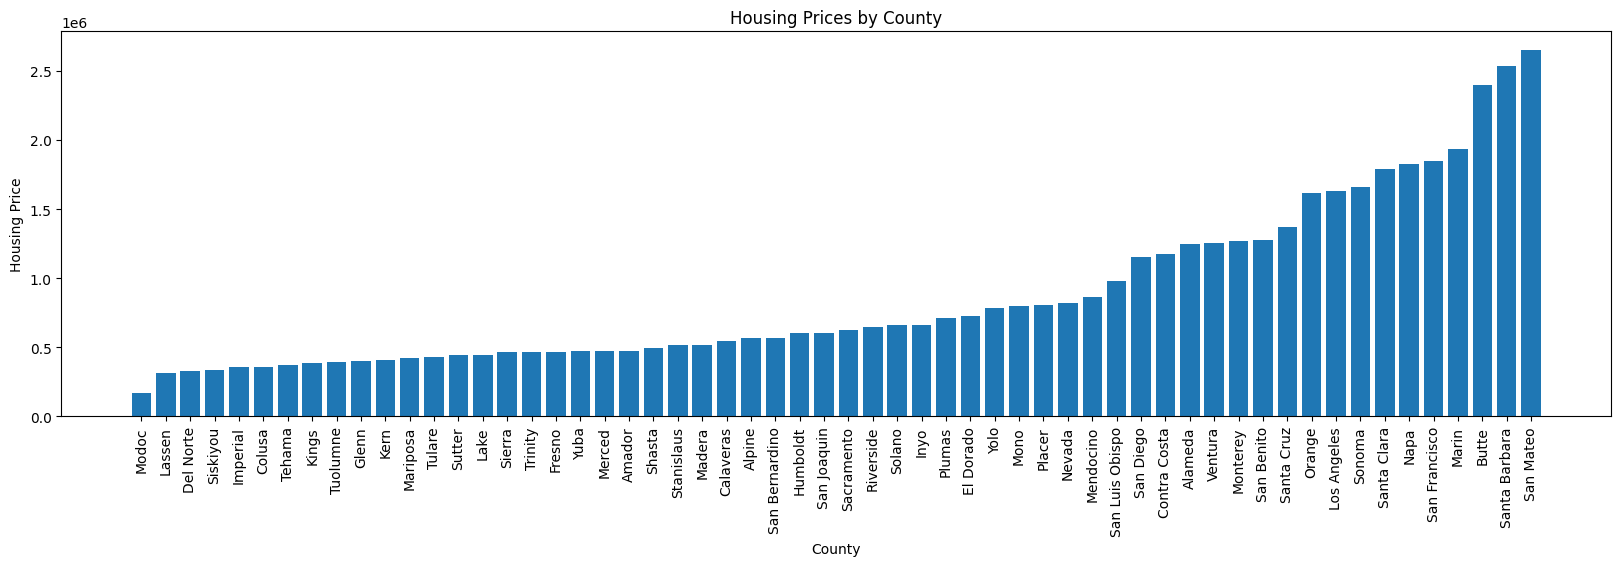

In [9]:
## Creating a bar chart that visualizes the Housing prices grouped by County
sorted_county = by_county.sort_values(by=['Price'])
plt.figure(figsize=(20,5))
plt.bar(sorted_county['County'], sorted_county['Price'])
plt.xticks(fontsize=10)
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('Housing Price')
plt.title("Housing Prices by County")
plt.show()

In [10]:
## Creating a correlation matrix of the variables
corr = by_county[['Price','Sqft', 'beds', 'baths', 'Sqft_of_Lot', 'Violent_Crime_Per_1000','Property_Crime_Per_1000', 'Median_Household_Income','Rank_Score']].corr()
print(corr)

                            Price      Sqft      beds     baths  Sqft_of_Lot   
Price                    1.000000  0.313379  0.065979  0.358872    -0.132716  \
Sqft                     0.313379  1.000000  0.579408  0.853228    -0.020047   
beds                     0.065979  0.579408  1.000000  0.564006    -0.122609   
baths                    0.358872  0.853228  0.564006  1.000000    -0.136707   
Sqft_of_Lot             -0.132716 -0.020047 -0.122609 -0.136707     1.000000   
Violent_Crime_Per_1000  -0.307989 -0.323143 -0.076902 -0.493136    -0.099636   
Property_Crime_Per_1000 -0.144864 -0.277641 -0.103879 -0.292172    -0.152988   
Median_Household_Income  0.685766  0.421170  0.139196  0.484455    -0.055199   
Rank_Score               0.509357  0.317420 -0.102789  0.304562    -0.060117   

                         Violent_Crime_Per_1000  Property_Crime_Per_1000   
Price                                 -0.307989                -0.144864  \
Sqft                                  -0.323143

In [11]:
## Creating a regression model of the most highly correlated variables
data = by_county[['Price','Median_Household_Income', 'Rank_Score', 'Sqft']]
data = data.dropna()
y = data['Price']
x = data[['Median_Household_Income', 'Rank_Score','Sqft']]
x= sm.add_constant(x)
regression_model = sm.OLS(y,x).fit()

print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     15.61
Date:                Sun, 07 May 2023   Prob (F-statistic):           2.29e-07
Time:                        21:57:50   Log-Likelihood:                -806.59
No. Observations:                  56   AIC:                             1621.
Df Residuals:                      52   BIC:                             1629.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -7

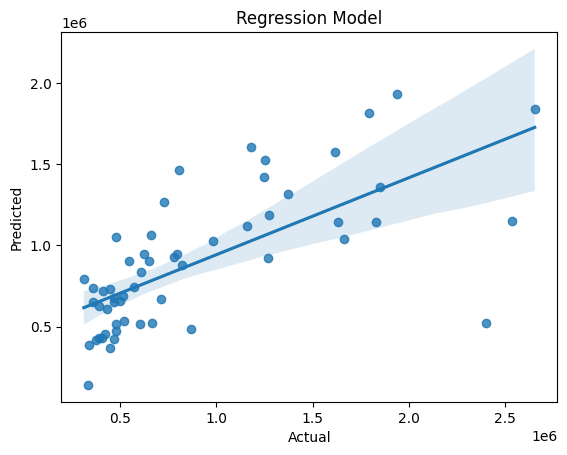

In [12]:
## Creating a plot of the regression model using seaborn
y_pred = regression_model.predict(x)
sns.regplot(x=y, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression Model')
plt.show()

In [13]:
## Creating a df that shows only the priciest 17 counties of California as those are the counties I am interested in living in.
interested_counties = by_county.sort_values('Price', ascending=False).head(17)
interested_counties = interested_counties.reset_index(drop = True)
print(interested_counties)


           County         Sqft      beds     baths   Sqft_of_Lot   
0       San Mateo  2210.114458  3.271084  2.765060  3.928035e+04  \
1   Santa Barbara  2047.982759  3.174603  2.790323  1.050858e+05   
2           Butte  1574.084337  3.024096  2.045455  8.284106e+04   
3           Marin  2068.493827  3.240964  2.560976  1.560518e+05   
4   San Francisco  1929.764706  3.111111  1.944186  1.500922e+04   
5            Napa  2097.312500  3.104167  2.448980  3.938078e+05   
6     Santa Clara  1915.959786  3.345013  2.603352  1.808978e+04   
7          Sonoma  2321.167883  3.281481  2.766917  3.146781e+05   
8     Los Angeles  2278.810284  3.641509  2.986318  3.030693e+04   
9          Orange  2121.492386  3.477462  2.983278  9.637272e+03   
10     Santa Cruz  1828.700000  2.928571  2.285714  5.890572e+04   
11     San Benito  2645.666667  3.571429  2.857143  5.950638e+05   
12       Monterey  1745.267857  3.000000  2.339286  1.001315e+06   
13        Ventura  2050.657143  3.340782  2.6592

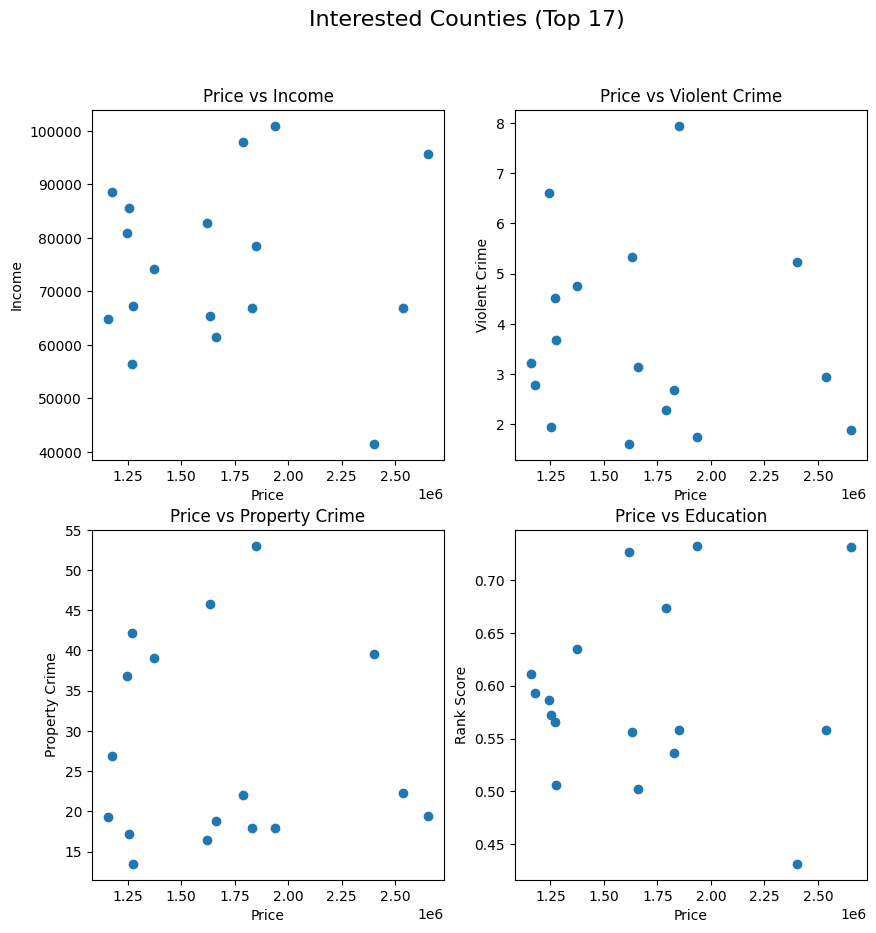

In [22]:
## Creating a scatterplot of Price against its respective correlated variables within the top 17 most expensive counties
figure, axis = plt.subplots(2,2,figsize= (10,10))

figure.suptitle('Interested Counties (Top 17)', fontsize=16)

axis[0,0].scatter(interested_counties['Price'], interested_counties['Median_Household_Income'])
axis[0,0].set_xlabel('Price')
axis[0,0].set_ylabel('Income')
axis[0,0].set_title('Price vs Income')

axis[0, 1].scatter(interested_counties['Price'], interested_counties['Violent_Crime_Per_1000'])
axis[0, 1].set_xlabel('Price')
axis[0, 1].set_ylabel('Violent Crime')
axis[0, 1].set_title('Price vs Violent Crime')

axis[1, 0].scatter(interested_counties['Price'], interested_counties['Property_Crime_Per_1000'])
axis[1, 0].set_xlabel('Price')
axis[1, 0].set_ylabel('Property Crime')
axis[1, 0].set_title('Price vs Property Crime')

axis[1, 1].scatter(interested_counties['Price'], interested_counties['Rank_Score'])
axis[1, 1].set_xlabel('Price')
axis[1, 1].set_ylabel('Rank Score')
axis[1, 1].set_title('Price vs Education')

plt.show()


In [23]:
## Creating a df that shows only the cheapest 17 counties of California as a comparison to the counties I was interested in.
non_interested_counties = by_county.sort_values('Price', ascending=True).head(17)
non_interested_counties = non_interested_counties.reset_index(drop = True)
print(non_interested_counties)

       County         Sqft      beds     baths   Sqft_of_Lot          Price   
0       Modoc   954.000000  2.000000  1.000000  6.098000e+03  170000.000000  \
1      Lassen  1722.846154  3.153846  2.230769  3.529551e+05  311207.692308   
2   Del Norte  1546.923077  3.307692  1.785714  3.452125e+04  331692.857143   
3    Siskiyou  1619.000000  3.347826  1.920000  2.228530e+05  337464.000000   
4    Imperial  1652.291667  3.666667  2.375000  1.523735e+04  357403.625000   
5      Colusa  1693.285714  3.142857  2.285714  5.557000e+04  358257.142857   
6      Tehama  1495.333333  2.904762  2.047619  1.425138e+05  373318.761905   
7       Kings  1727.913043  3.130435  1.913043  1.517763e+07  389443.478261   
8    Tuolumne  1626.259259  2.888889  2.034483  6.396870e+04  391298.275862   
9       Glenn  1523.000000  3.333333  2.000000  3.397700e+04  405000.000000   
10       Kern  1945.576087  3.657534  2.396154  3.021550e+04  409041.190000   
11   Mariposa  1752.555556  2.333333  1.600000  2.75

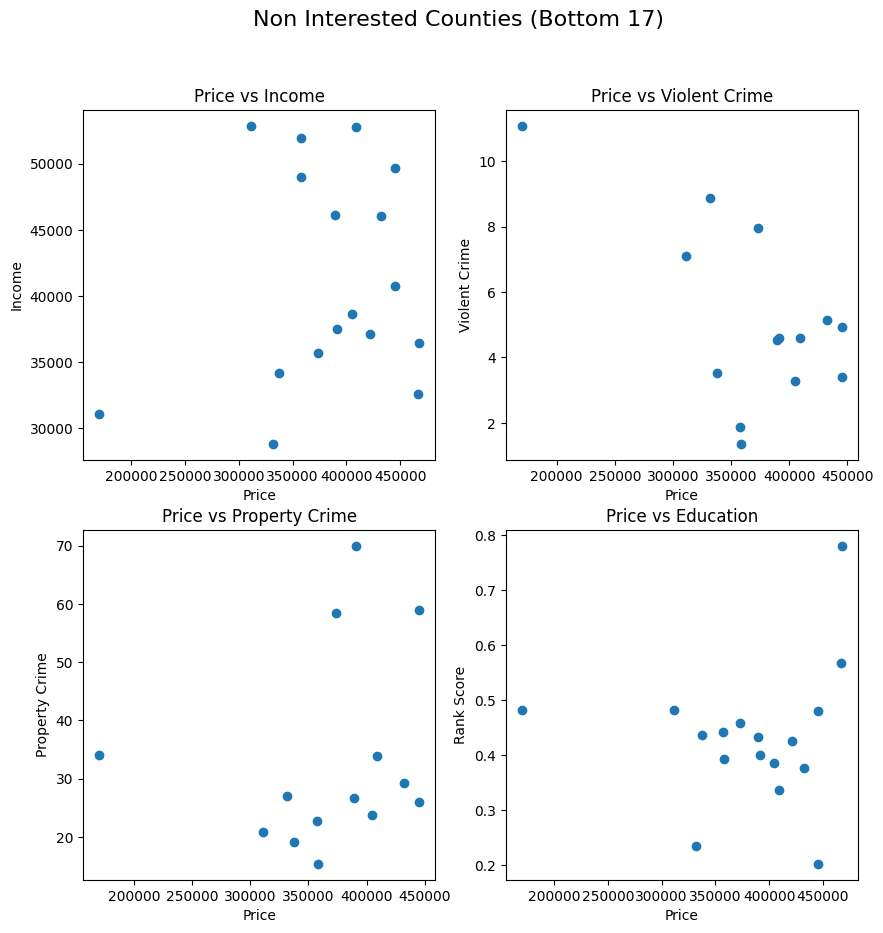

In [24]:
## Creating a scatterplot of Price against its respective correlated variables within the 17 least expensive counties
figure, axis = plt.subplots(2,2,figsize= (10,10))

figure.suptitle('Non Interested Counties (Bottom 17)', fontsize=16)


axis[0,0].scatter(non_interested_counties['Price'], non_interested_counties['Median_Household_Income'])
axis[0,0].set_xlabel('Price')
axis[0,0].set_ylabel('Income')
axis[0,0].set_title('Price vs Income')

axis[0, 1].scatter(non_interested_counties['Price'], non_interested_counties['Violent_Crime_Per_1000'])
axis[0, 1].set_xlabel('Price')
axis[0, 1].set_ylabel('Violent Crime')
axis[0, 1].set_title('Price vs Violent Crime')

axis[1, 0].scatter(non_interested_counties['Price'], non_interested_counties['Property_Crime_Per_1000'])
axis[1, 0].set_xlabel('Price')
axis[1, 0].set_ylabel('Property Crime')
axis[1, 0].set_title('Price vs Property Crime')

axis[1, 1].scatter(non_interested_counties['Price'], non_interested_counties['Rank_Score'])
axis[1, 1].set_xlabel('Price')
axis[1, 1].set_ylabel('Rank Score')
axis[1, 1].set_title('Price vs Education')

plt.show()


In [20]:
## Attempting to address multicollinearity issues using PCA transformation
by_county['Rank_Score'].fillna(by_county['Rank_Score'].median(),inplace = True)
data = by_county[['Median_Household_Income', 'Rank_Score', 'Sqft']]
pca = PCA(n_components=1)
pca.fit(data)
data_pca = pca.transform(data)
by_county['pca'] = data_pca
Y = by_county['Price']
X = by_county[['pca']]
X= sm.add_constant(X)
model = sm.OLS(Y,X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     49.72
Date:                Sun, 07 May 2023   Prob (F-statistic):           2.85e-09
Time:                        21:59:14   Log-Likelihood:                -835.44
No. Observations:                  58   AIC:                             1675.
Df Residuals:                      56   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.722e+05   5.82e+04     14.973      0.0